I've been wondering how far one can get in this competition using an unsupervised learning approach. So I decided to play with the contextual embeddings I obtained from BERT in my previous [kernel](https://www.kaggle.com/mateiionita/taming-the-bert-a-baseline), and try to make predictions without having a training set with ground truth labels.

Spoiler alert: I didn't get very far, the best score I could get was around 0.93. Still, I think it's instructive to visualize some of the output of BERT. Specifically, I'm looking at:
* The Euclidean distance d(A,P) between the embeddings of the Pronoun and the target word A.
* The Euclidean distance d(B,P).
* The Euclidean distance d(A,B) between the two target words.

This is low-dimensional information that you can plot, and then use to make predictions for the coreference resolution problem. The simplest approach would be:
* If d(A,B) is large compared to d(A,P) and d(B,P), in a sense that will be made precise later, classify the data as "Neither".
* Otherwise, if d(A,P) < d(B,P), classify the data as "A". If d(A,P) > d(B,P), classify the data as "B".

This is more or less what I do below. To obtain class probabilities, I pass the distances through a softmax function.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
% matplotlib inline

['taming-the-bert-a-baseline', 'gendered-pronoun-resolution']


In [2]:
emb_size = 768

def parse_json(embeddings):
	'''
	Parses the embeddigns given by BERT, and suitably formats them to be passed to the MLP model

	Input: embeddings, a DataFrame containing contextual embeddings from BERT, as well as the labels for the classification problem
	columns: "emb_A": contextual embedding for the word A
	         "emb_B": contextual embedding for the word B
	         "emb_P": contextual embedding for the pronoun
	         "label": the answer to the coreference problem: "A", "B" or "NEITHER"

	Output: X, a numpy array containing, for each line in the GAP file, the concatenation of the embeddings of the target words
	        Y, a numpy array containing, for each line in the GAP file, the one-hot encoded answer to the coreference problem
	'''
	embeddings.sort_index(inplace = True) # Sorting the DataFrame, because reading from the json file messed with the order
	X = np.zeros((len(embeddings),3*emb_size))
	Y = np.zeros((len(embeddings), 3))

	# Concatenate features
	for i in range(len(embeddings)):
		A = np.array(embeddings.loc[i,"emb_A"])
		B = np.array(embeddings.loc[i,"emb_B"])
		P = np.array(embeddings.loc[i,"emb_P"])
		X[i] = np.concatenate((A,B,P))

	# One-hot encoding for labels
	for i in range(len(embeddings)):
		label = embeddings.loc[i,"label"]
		if label == "A":
			Y[i,0] = 1
		elif label == "B":
			Y[i,1] = 1
		else:
			Y[i,2] = 1

	return X, Y

I'm reading the contextual embeddings obtained from BERT in my previous kernel, and saved in a json file. I'm also reading true labels, which are used in the plot below, and to evaluate the performance at the end.

In [3]:
development = pd.read_json("../input/taming-the-bert-a-baseline/contextual_embeddings_gap_development.json")
X_development, Y_development = parse_json(development)

# There may be a few NaN values, where the offset of a target word is greater than the max_seq_length of BERT.
# They are very few, so rather than dealing with the problem, I'm replacing those rows with random values.
remove_development = [row for row in range(len(X_development)) if np.sum(np.isnan(X_development[row]))]
X_development[remove_development] = np.random.randn(3*emb_size)

Compute the Euclidean distances between contextual embeddings.

In [4]:
n_rows = len(X_development)
index = list(range(n_rows))
distance = pd.DataFrame(index = index, columns = ["d_PA", "d_PB", "d_AB"])
for i in index:
	distance.loc[i,"d_PA"] = np.linalg.norm(X_development[i,2*emb_size:] - X_development[i,:emb_size], ord = 2)  
	distance.loc[i,"d_PB"] = np.linalg.norm(X_development[i,emb_size:2*emb_size] - X_development[i,2*emb_size:], ord = 2) 
	distance.loc[i,"d_AB"] = np.linalg.norm(X_development[i,:emb_size] - X_development[i,emb_size:2*emb_size], ord = 2)

Plot the relative sizes of the distances computed above. The purple points, which have true label "A", tend to appear in the left half of the plot. The blue points, which have true label "B", tend to appear in the right. Finally, the yellow points, which have class "Neither", are more likely to appear towards the bottom.

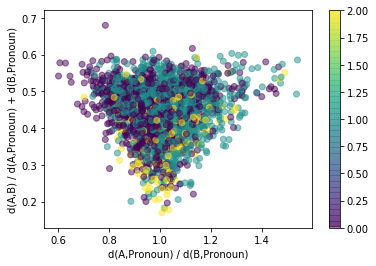

In [5]:
plt.scatter(distance["d_PA"] / distance["d_PB"], 
            distance["d_AB"] / (distance["d_PB"]+ distance["d_PA"]), 
            c = np.argmax(Y_development[:n_rows], axis = 1), 
            alpha = 0.5)
plt.xlabel("d(A,Pronoun) / d(B,Pronoun)")
plt.ylabel("d(A,B) / d(A,Pronoun) + d(B,Pronoun)")
plt.colorbar()
plt.show()

For prediction, I want to compare d(A,P)/d(B,P) to 1, and d(A,B) /  (d(B,P) + d(A,P)) to some threshold value, then pass these through a softmax function to obtain probabilities. This threshold is the only parameter in my model. Finding an appropriate value for it is where I'm cheating and using information about the true labels. Intuitively, there are much fewer "Neither" data points than either "A" or "B". Choosing a negative threshold biases the probability for class "Neither" to be very low

In [10]:
threshold = -1

def softmax(v):
	exp = np.exp(v)
	return exp / np.sum(exp, axis = 1, keepdims = True)

distance["A/B"] = 1- distance["d_PA"] / distance["d_PB"] 
distance["B/A"] = 1- distance["d_PB"] / distance["d_PA"]  
distance["N/A+B"] = threshold - distance["d_AB"] / (distance["d_PB"]+ distance["d_PA"])
values = distance[["A/B", "B/A", "N/A+B"]].values.astype(float)
prediction = softmax(values)
print("The score is :", log_loss(Y_development, prediction))

The score is : 0.9295492190014274


The score is nothing to write home about, but I had my fun.

In [8]:
submission = pd.read_csv("../input/gendered-pronoun-resolution/sample_submission_stage_1.csv", index_col = "ID")
submission["A"] = prediction[:,0]
submission["B"] = prediction[:,1]
submission["NEITHER"] = prediction[:,2]
submission.to_csv("submission_bert_more_data.csv")